In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from segmentflow import segment, view, mesh
from skimage import exposure, util
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Loading images...
--> Images loaded as 3D array:  (200, 200, 200)


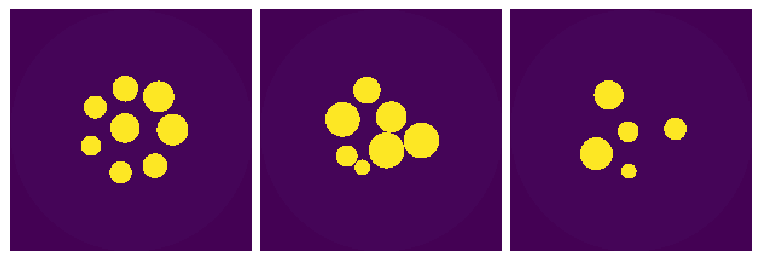

In [42]:
ui = {
    'in_dir_path'          : '../../mhe-analysis/data/fake-ct/Res2',
    'file_suffix'          : 'tiff',
    'slice_crop'           : None,
    'row_crop'             : None,
    'col_crop'             : None,
    'out_dir_path'         : '../results/fake-ct/Res2',
    'out_prefix'           : 'Res2_smoothed',
    'overwrite'            : True,
    'view_slices'          : [75, 125, 175],
    'view_raw'             : True,
    'view_pre'             : True,
    'view_semantic'        : True,
    'view_labeled'         : True,
    'pre_seg_med_filter'   : False,
    'rescale_range'        : None,
    'thresh_nbins'         : 256,
    'view_thresh_hist'     : True,
    'thresh_hist_ylims'    : None,
    'perform_seg'          : True,
    'min_peak_dist'        : 6,
    'exclude_borders'      : True,
    'save_voxels'          : False,
    'create_stls'          : True,
    'n_erosions'           : 0,
    'post_seg_med_filter'  : True,
    'spatial_res'          : 1,
    'voxel_step_size'      : 1,
    'suppress_save_msg'    : True,
    'mesh_smooth_n_iters'  : 1,
    'mesh_simplify_n_tris' : None,
    'mesh_simplify_factor' : None,
    'seg_fig_show'         : False,
}
#-------------#
# Load images #
#-------------#
print()
imgs = segment.load_images(
    ui['in_dir_path'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=False,
    file_suffix=ui['file_suffix']
)
fig, axes = view.plot_slices(
        imgs,
        slices=ui['view_slices'],
        print_slices=False,
        fig_w=7.5,
        dpi=100
    )

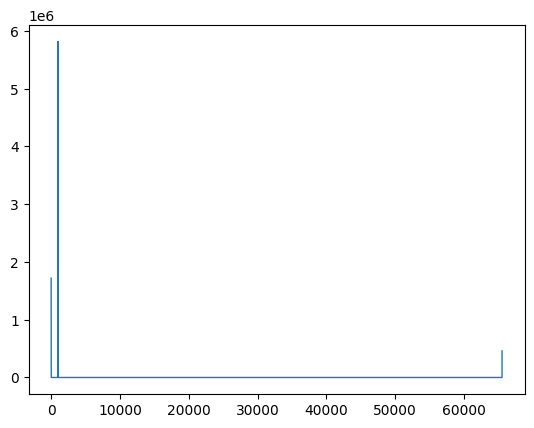

In [24]:
hist, hist_centers = exposure.histogram(imgs)
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, lw=1)

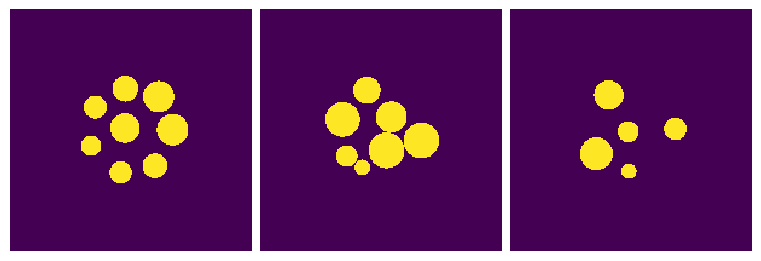

In [27]:
#-----------------------#
# Semantic segmentation #
#-----------------------#
print()
imgs_semantic = imgs.copy()
imgs_semantic[imgs < imgs.max()] = 0
if ui['view_semantic']:
    fig, axes = view.plot_slices(
            imgs_semantic,
            slices=ui['view_slices'],
            print_slices=False,
            fig_w=7.5,
            dpi=100
        )



Segmenting images...
--> Number of particle(s) before border exclusion:  32
--> Excluding border particles...
--> Segmentation complete. 32 particle(s) segmented.


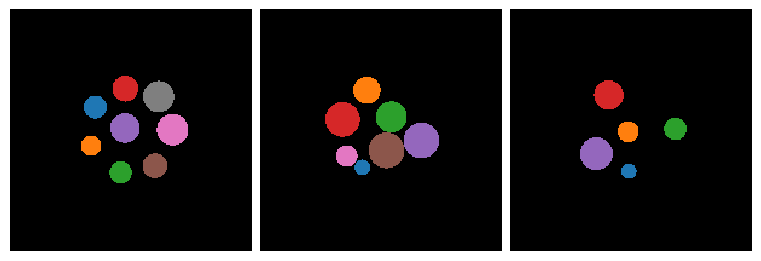

In [29]:
#-----------------------#
# Instance segmentation #
#-----------------------#
if ui['perform_seg']:
    print()
    imgs = None
    imgs_pre = None
    imgs_labeled = segment.watershed_segment(
        imgs_semantic,
        min_peak_distance=ui['min_peak_dist'],
        exclude_borders=ui['exclude_borders'],
        return_dict=False
    )
    if ui['view_labeled']:
        fig, axes = view.plot_color_labels(
            imgs_labeled,
            slices=ui['view_slices'],
            fig_w=7.5,
            dpi=100
        )
    if ui['save_voxels']:
        segment.save_images(
            imgs_labeled,
            Path(ui['out_dir_path']) / f"{ui['out_prefix']}_labeled_voxels"
        )

In [48]:
#----------------------------------------#
# Create Surface Meshes of Each Particle #
#----------------------------------------#
if ui['perform_seg'] and ui['create_stls']:
    print()
    stl_dir_path = segment.save_as_stl_files(
        imgs_labeled,
        ui['out_dir_path'],
        ui['out_prefix'],
        suppress_save_msg=ui['suppress_save_msg'],
        slice_crop=ui['slice_crop'],
        row_crop=ui['row_crop'],
        col_crop=ui['col_crop'],
        stl_overwrite=ui['overwrite'],
        spatial_res=ui['spatial_res'],
        n_erosions=ui['n_erosions'],
        median_filter_voxels=ui['post_seg_med_filter'],
        voxel_step_size=ui['voxel_step_size'],
        return_stl_dir_path=True
    )

    #----------------------------------------------#
    # Postprocess surface meshes for each particle #
    #----------------------------------------------#
    if (
        ui['mesh_smooth_n_iters'] is not None
        or ui['mesh_simplify_n_tris'] is not None
        or ui['mesh_simplify_factor'] is not None
    ):
        print()
        # Iterate through each STL file, load the mesh, and smooth/simplify
        mesh.postprocess_meshes(
            stl_dir_path,
            smooth_iter=ui['mesh_smooth_n_iters'],
            simplify_n_tris=ui['mesh_simplify_n_tris'],
            iterative_simplify_factor=ui['mesh_simplify_factor'],
            recursive_simplify=False, resave_mesh=True
        )



Generating surface meshes...
--> 32 STL file(s) written!

Postprocessing surface meshes...
--> 32 surface meshes postprocessed.
